# Neural Networks: Multilayer Perceptron (MLP) with PyTorch

- Neural Networks can have a massice number of parameters, with dozens of layers, meaning the model will have a lot of work to learn and optimize everything!
- Well, this is exactly Deep Learning 
- To help this networks building, Pytorch has a module called `nn`


In [4]:
import torch
from torchvision import datasets, transforms

# for better image plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# defining transforms for data normalization 
transform = transforms.Compose([transforms.ToTensor(),                  # setting PIL image --> pytorch tensor
                                transforms.Normalize((0.5,), (0.5,))])   # B/W only have 2 channels

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])   # normalize only 2 channels bc it's a B&W picture

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### We created a  `trainloader` and now we'll pass an _iterator_ `iter(trainloader)`:

```python
for image, label in trainloader:
    ## do things with images and labels
```

### Note that the batch_size here is 64, so let's check it out the first batch:
- `images` is a vector with size `(64, 1, 28, 28)`, that means, 64 images / batch, $1$ color per channel  (RBG it woulb be 3 channels), the the size of the images are 28x28 pixels.

In [8]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


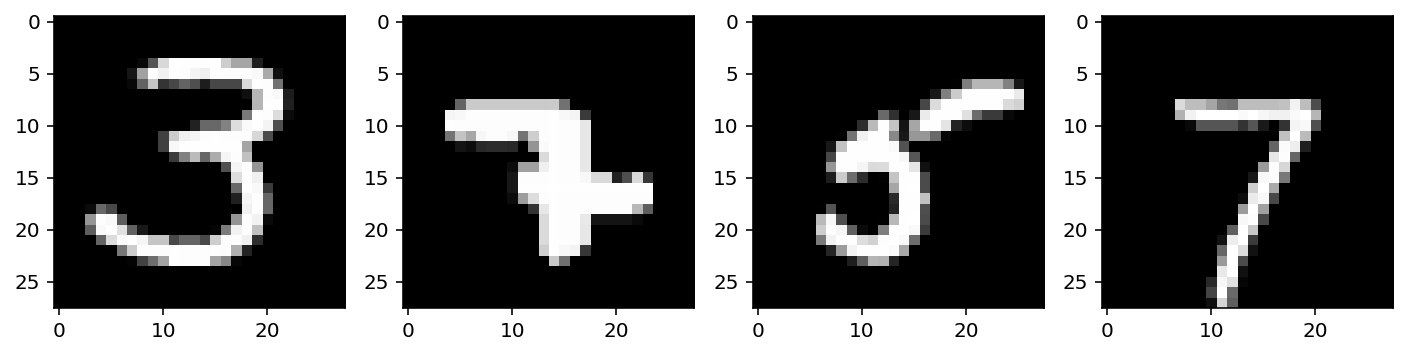

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(12,4))
for i in range(4):
    ax[i].imshow(images[i].numpy().squeeze(), cmap='Greys_r');

## To understand the theory behind neural networks, I'll first build one using matrix multiplication
- After, I'll use the module `nn`

## MLP layers:
- are called *fully-connected* or *dense*
- all units from one layer are connected to all units from the next layer
- The input from each layer must be a 1D vector
- So, in the MNIST example here, the 28x28 px images will be converted to tensors of 784 units
- Thus, the tensor: `(64, 1, 28, 28)` will be converted to: `(64, 784)`
- This procedure is called *flattening* ( 2Dtensor -------> 1Dtensor )

## At this example, we have the **input**, one **hidden** and the **output** layers:

In [16]:
## activation function
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

# Flattening: keeps the first dimension (64), which is the batch_size and transforms the other dimension in one
inputs =  images.view(images.shape[0],-1)

# defining the weights that connect the input layer to the hidden layer
W1 = torch.randn(inputs.shape[1] , 256)         ###  Note that the hidden layer has 256 neurons:

# defining the weights that connect the hidden layer to the output layer
W2 = torch.randn(256, 10)             ### Note that the output layer has 10 neurons (=classify 10 digits)

# defining the bias term: first fot the hidden layer and than for the output layer (same number of neurons)
B1 = torch.randn(256)
B2 = torch.randn(10)

# compute the hidden layer terms passing the activation function:
h = sigmoid(torch.mm(inputs,W1) + B1)        ### mm: matrix multiplication

# computes the network output:
out = torch.mm(h,W2) + B2                

## With those 10 outputs, we want to know which class does the image belong to
- Thus, we compute the probability associated with each class
- This probability is computed with the function **Softmax**, defined as:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

- This function _squeezes_ the output to values between 0 and 1
- Then, the value is normalized 
- The sum of the probabilities (of each class) is always going to be = 1

## Defining the Softmax functiona according to the equation above:
- dim = 1 : the sum is going through each class, not through each sample
- The softmax returns a tensor with 64x10, that means for each image (from the batch) the class which it belongs to

In [17]:
def softmax(x):
    """Defining the Softmax function."""
    return torch.exp(x)/torch.sum(torch.exp(x),dim = 1).view(-1,1)

In [18]:
# probabilities is the output of the softmax size: (64,10) 
probabilities = softmax(out)

print(probabilities.shape)

torch.Size([64, 10])


In [20]:
# Checking the sum of the all the probabilities for 10 classes == 1
print(probabilities.sum(dim=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building the network with `nn` pytorch
- creating a class called `Network` which inherits from `nn.module`
- parameters: 
- `nn.Linear`: Applies a linear transformation to the incoming data:
    - self.hidden : input is **28x28pixels** to **256** at the hidden layer
        - This module creates the **weights** and **bias** tensors
        - These new tensors will be used in `forward` method 
        - To check these tensors out we can:
            - Instantiate the network and pass `net.hidden.weight` and `net.hidden.bias`.
    
    - self.output : **256** from the hidden to **10** in output
    - sigmoid and softmax (again passing dim = 1): defining the activation and output functions  
- `Forward` method:
    - receives "x" and passes the tensor for each operation

In [22]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # linear transformation 784 from input layer to 256 at the hidden layer 
        self.hidden = nn.Linear(784, 256)
        # again, from hidden to output
        self.output = nn.Linear(256, 10)
        
        # Define Sigmoid and Softmax functions
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # the forward method passes the x tensor through each operation
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [23]:
# creating the network
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

## Creating the Network class in a much easier way

In [ ]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = F.softmax(self.output(x), dim=1
        return x